# BIG DATA PROCESSIN PROJECT

In [52]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc, col, isnan, when, count, mean ,stddev, expr, lit,avg

from pyspark.sql.types import StructType, StructField, StringType, DoubleType

###  Create a SparkSession

In [24]:

spark = SparkSession.builder.appName("Happy Countries").getOrCreate()

In [25]:
spark

## Data loading and cleaning

### Read CSV File into DataFrame with my_schema

In [26]:
years = [2015, 2016,2017,2018,2019,2020,2021,2022,2023]

In [27]:
# Create file path
csv_file_paths = [f"./data/WHR_{year}.csv" for year in years]

In [28]:
df_schema = StructType([
    StructField("Country", StringType(), True),
    StructField("Region", StringType(),True),
    StructField("Happiness_Score",DoubleType(), True),
    StructField("GDP_per_Capita",DoubleType(), True),
    StructField("Social_Support", DoubleType(), True),
    StructField("Healthy_Life_Expectancy", DoubleType(), True),
    StructField("Freedom_to_Make_Life_Choices", DoubleType(), True),
    StructField("Generosity", DoubleType(), True),
    StructField("Perceptions_of_Corruption", DoubleType(), True)

])

In [29]:
# Read csv

dfs = []
for year, path in zip(years, csv_file_paths):
    df = spark.read.csv(path, header=True, schema=df_schema)
    df = df.withColumn("year",lit(year))
    dfs.append(df)

In [40]:
dfs[1].head()

Row(Country='Denmark', Region='Western Europe', Happiness_Score=7.526, GDP_per_Capita=1.44178, Social_Support=1.16374, Healthy_Life_Expectancy=0.79504, Freedom_to_Make_Life_Choices=0.57941, Generosity=0.36171, Perceptions_of_Corruption=0.44453, year=2016)

In [30]:
# Union 
end_df = dfs[0]
for df in dfs[1:]:
    end_df = end_df.unionByName(df)

In [31]:
# Display schema of DataFrame
end_df.show()

+--------------------+--------------------+---------------+--------------+--------------+-----------------------+----------------------------+----------+-------------------------+----+
|             Country|              Region|Happiness_Score|GDP_per_Capita|Social_Support|Healthy_Life_Expectancy|Freedom_to_Make_Life_Choices|Generosity|Perceptions_of_Corruption|year|
+--------------------+--------------------+---------------+--------------+--------------+-----------------------+----------------------------+----------+-------------------------+----+
|         Switzerland|      Western Europe|          7.587|       1.39651|       1.34951|                0.94143|                     0.66557|   0.29678|                  0.41978|2015|
|             Iceland|      Western Europe|          7.561|       1.30232|       1.40223|                0.94784|                     0.62877|    0.4363|                  0.14145|2015|
|             Denmark|      Western Europe|          7.527|       1.32548| 

In [32]:
# Display schema of DataFrame
end_df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Happiness_Score: double (nullable = true)
 |-- GDP_per_Capita: double (nullable = true)
 |-- Social_Support: double (nullable = true)
 |-- Healthy_Life_Expectancy: double (nullable = true)
 |-- Freedom_to_Make_Life_Choices: double (nullable = true)
 |-- Generosity: double (nullable = true)
 |-- Perceptions_of_Corruption: double (nullable = true)
 |-- year: integer (nullable = false)



### Calculating basic statistics

In [36]:
end_df.describe().show()

+-------+-----------+--------------+------------------+------------------+-------------------+-----------------------+----------------------------+-------------------+-------------------------+------------------+
|summary|    Country|        Region|   Happiness_Score|    GDP_per_Capita|     Social_Support|Healthy_Life_Expectancy|Freedom_to_Make_Life_Choices|         Generosity|Perceptions_of_Corruption|              year|
+-------+-----------+--------------+------------------+------------------+-------------------+-----------------------+----------------------------+-------------------+-------------------------+------------------+
|  count|       1367|          1367|              1367|              1367|               1367|                   1366|                        1367|               1367|                     1366|              1367|
|   mean|       NULL|          NULL| 5.441086100337234|1.0194221765435258|  1.045334121149232|     0.5840431547291361|          0.4507711995354792|0

### Null value analysis

In [37]:
null_counts = end_df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in end_df.columns])
null_counts.show()

+-------+------+---------------+--------------+--------------+-----------------------+----------------------------+----------+-------------------------+----+
|Country|Region|Happiness_Score|GDP_per_Capita|Social_Support|Healthy_Life_Expectancy|Freedom_to_Make_Life_Choices|Generosity|Perceptions_of_Corruption|year|
+-------+------+---------------+--------------+--------------+-----------------------+----------------------------+----------+-------------------------+----+
|      0|     0|              0|             0|             0|                      1|                           0|         0|                        1|   0|
+-------+------+---------------+--------------+--------------+-----------------------+----------------------------+----------+-------------------------+----+



In [38]:
df_cleaned= end_df.dropna(subset=["Healthy_Life_Expectancy","Perceptions_of_Corruption"])

In [39]:
df_cleaned.count()

1365

## Exploratory Data Analysis (EDA)

### Distribution of Happiness

In [41]:
happiness_stats = df_cleaned.select(
    mean(col("Happiness_Score")).alias("mean"),
    stddev(col("Happiness_Score")).alias("stddev"),
    expr("percentile_approx(Happiness_Score, 0.25)").alias("Q1"),
    expr("percentile_approx(Happiness_Score, 0.5)").alias("median"),
    expr("percentile_approx(Happiness_Score, 0.75)").alias("Q3")
)

happiness_stats.show()

+-----------------+-----------------+-----+------+-----+
|             mean|           stddev|   Q1|median|   Q3|
+-----------------+-----------------+-----+------+-----+
|5.440500145905494|1.118053079366458|4.596|  5.44|6.255|
+-----------------+-----------------+-----+------+-----+



## Correlation of factors with happiness

To find the correlation between each factor and the Happiness_Score, we will use the correlation function in PySpark for each factor. Here we assume that there are several columns of factors, for example: GDP_Per_Capita, Social_Support, Life_Expectancy, etc.

In [42]:
from pyspark.sql.functions import corr
from pyspark.sql import Row

In [43]:
# List of factors we want to correlate with happines_score
factor_columns = ["GDP_per_Capita","Social_Support","Healthy_Life_Expectancy","Freedom_to_Make_Life_Choices","Generosity","Perceptions_of_Corruption"]

In [44]:
correlation_data = []

In [45]:
# Calculate the correlation of each factor
for factor in factor_columns:
    correlation = df_cleaned.select(corr("Happiness_Score",factor).alias("correlation")).collect()[0]["correlation"]
    print(f"Correlation between Happiness_Score and {factor}: {correlation}")
    correlation_data.append(Row(Factor=factor,Correlation=correlation))

Correlation between Happiness_Score and GDP_per_Capita: 0.723784949432059
Correlation between Happiness_Score and Social_Support: 0.6498436290451899
Correlation between Happiness_Score and Healthy_Life_Expectancy: 0.682479558984849
Correlation between Happiness_Score and Freedom_to_Make_Life_Choices: 0.5709017429407508
Correlation between Happiness_Score and Generosity: 0.08210993118693721
Correlation between Happiness_Score and Perceptions_of_Corruption: 0.4149541173536084


In [46]:
correlation_df = spark.createDataFrame(correlation_data)
correlation_df = correlation_df.orderBy("Correlation", ascending=False)
correlation_df.show()

+--------------------+-------------------+
|              Factor|        Correlation|
+--------------------+-------------------+
|      GDP_per_Capita|  0.723784949432059|
|Healthy_Life_Expe...|  0.682479558984849|
|      Social_Support| 0.6498436290451899|
|Freedom_to_Make_L...| 0.5709017429407508|
|Perceptions_of_Co...| 0.4149541173536084|
|          Generosity|0.08210993118693721|
+--------------------+-------------------+



### Annual and Regional Trends

In [49]:
# Average Happiness_Score by Year
annual_trend = df_cleaned.groupBy("year").agg(mean("Happiness_Score").alias("AVG_Happiness_Score"))
annual_trend.orderBy("AVG_Happiness_Score",ascending=False).show()
                                             

+----+-------------------+
|year|AVG_Happiness_Score|
+----+-------------------+
|2022|   5.55357534246575|
|2023|  5.544441176470589|
|2021|  5.532838926174494|
|2020|   5.47323986284967|
|2019|  5.407096153846153|
|2016|  5.382184713375795|
|2015| 5.3757341772151905|
|2018|  5.366896774193549|
|2017|  5.354019355774192|
+----+-------------------+



In [51]:
# Average Happiness_Score by Region
region_trend = df_cleaned.groupBy("Region").agg(mean("Happiness_Score").alias("AVG_Happiness_Score"))
region_trend.orderBy("AVG_Happiness_Score",ascending=False).show(truncate=False)

+----------------------------------+-------------------+
|Region                            |AVG_Happiness_Score|
+----------------------------------+-------------------+
|North America and ANZ             |7.176058332472223  |
|Western Europe                    |6.811460638909575  |
|Latin America and Caribbean       |5.993860526805262  |
|East Asia                         |5.732149987592593  |
|Commonwealth of Independent States|5.639040905886364  |
|Central and Eastern Europe        |5.585753270855141  |
|Southeast Asia                    |5.3704287529       |
|Middle East and North Africa      |5.26798553601258   |
|Africa                            |5.057              |
|South Asia                        |4.473263924868853  |
|Sub-Saharan Africa                |4.288796142305638  |
+----------------------------------+-------------------+



## Relevant Groupings and Filtering

In [55]:
# Grouping by region and calculation of average Happiness_Score and other factors 
region_summary = df_cleaned.groupBy("Region").agg(
    avg("Happiness_Score").alias("AVG_Happiness_Score"),
    avg("GDP_per_Capita").alias("AVG_GDP_per_Capita"),
    avg("Social_Support").alias("AVG_Social_Support"),
    avg("Healthy_Life_Expectancy").alias("AVG_Healthy_Life_Expectancy"),
    avg("Freedom_to_Make_Life_Choices").alias("AVG_Freedom"),
    avg("Generosity").alias("AVG_Generosity"),
    avg("Perceptions_of_Corruption").alias("AVG_Perceptions_of_Corruption")
)

region_summary.show()

+--------------------+-------------------+-------------------+------------------+---------------------------+-------------------+-------------------+-----------------------------+
|              Region|AVG_Happiness_Score| AVG_GDP_per_Capita|AVG_Social_Support|AVG_Healthy_Life_Expectancy|        AVG_Freedom|     AVG_Generosity|AVG_Perceptions_of_Corruption|
+--------------------+-------------------+-------------------+------------------+---------------------------+-------------------+-------------------+-----------------------------+
|          South Asia|  4.473263924868853| 0.7328129685409837|0.7473223635081967|         0.4896550032622951| 0.4237290859180328| 0.2534539122459016|          0.09941797308196722|
|Middle East and N...|   5.26798553601258|  1.157150908144654|0.9732086901006292|         0.6319705412955975| 0.3733136363962264|0.15596198787421384|           0.1356116103962264|
|North America and...|  7.176058332472223| 1.5018248203888886|1.3518091635555554|         0.81784629

In [56]:
# Grouping by Country and calculation of average Happiness_Score and other factors 
country_summary = df_cleaned.groupBy("Country").agg(
    avg("Happiness_Score").alias("AVG_Happiness_Score"),
    avg("GDP_per_Capita").alias("AVG_GDP_per_Capita"),
    avg("Social_Support").alias("AVG_Social_Support"),
    avg("Healthy_Life_Expectancy").alias("AVG_Healthy_Life_Expectancy"),
    avg("Freedom_to_Make_Life_Choices").alias("AVG_Freedom"),
    avg("Generosity").alias("AVG_Generosity"),
    avg("Perceptions_of_Corruption").alias("AVG_Perceptions_of_Corruption")
)

country_summary.show()

+------------+-------------------+------------------+-------------------+---------------------------+-------------------+-------------------+-----------------------------+
|     Country|AVG_Happiness_Score|AVG_GDP_per_Capita| AVG_Social_Support|AVG_Healthy_Life_Expectancy|        AVG_Freedom|     AVG_Generosity|AVG_Perceptions_of_Corruption|
+------------+-------------------+------------------+-------------------+---------------------------+-------------------+-------------------+-----------------------------+
|        Chad|  4.160300004111111|0.4168189417777778| 0.7310415722222223|        0.09457986833333333| 0.2144470884444444|0.20316099311111113|          0.06983858777777778|
|    Paraguay|  5.666011119888889|0.9993453488888888|  1.312818048888889|         0.6128944821111112| 0.5583730948888889| 0.2105344332222222|           0.0693914768888889|
|      Russia|  5.681777758333333|1.3020775237777777|  1.281967388666667|         0.5861072493333332|0.38432141188888885|0.07551730422222222

In [59]:
# Grouping by Country and Region and calculation of average Happiness_Score and other factors 
region_country_summary = df_cleaned.groupBy("Region","Country").agg(
    avg("Happiness_Score").alias("AVG_Happiness_Score"),
    avg("GDP_per_Capita").alias("AVG_GDP_per_Capita"),
    avg("Social_Support").alias("AVG_Social_Support"),
    avg("Healthy_Life_Expectancy").alias("AVG_Healthy_Life_Expectancy"),
    avg("Freedom_to_Make_Life_Choices").alias("AVG_Freedom"),
    avg("Generosity").alias("AVG_Generosity"),
    avg("Perceptions_of_Corruption").alias("AVG_Perceptions_of_Corruption")
)

region_country_summary.orderBy("Region").show(truncate=False)

+--------------------------+----------------------+-------------------+------------------+------------------+---------------------------+-------------------+--------------------+-----------------------------+
|Region                    |Country               |AVG_Happiness_Score|AVG_GDP_per_Capita|AVG_Social_Support|AVG_Healthy_Life_Expectancy|AVG_Freedom        |AVG_Generosity      |AVG_Perceptions_of_Corruption|
+--------------------------+----------------------+-------------------+------------------+------------------+---------------------------+-------------------+--------------------+-----------------------------+
|Africa                    |Somaliland region     |5.057              |0.18847           |0.95152           |0.43873                    |0.46582            |0.50318             |0.39928                      |
|Africa                    |Somaliland Region     |5.057              |0.25558           |0.75862           |0.33108                    |0.3913             |0.51479

In [61]:
region_country_summary.orderBy("AVG_Happiness_Score",ascending=False).show(truncate=False)

+----------------------------+--------------+-------------------+------------------+------------------+---------------------------+-------------------+-------------------+-----------------------------+
|Region                      |Country       |AVG_Happiness_Score|AVG_GDP_per_Capita|AVG_Social_Support|AVG_Healthy_Life_Expectancy|AVG_Freedom        |AVG_Generosity     |AVG_Perceptions_of_Corruption|
+----------------------------+--------------+-------------------+------------------+------------------+---------------------------+-------------------+-------------------+-----------------------------+
|Western Europe              |Finland       |7.662744438666666  |1.4773323815555555|1.402296958888889 |0.8201610083333333         |0.6632219552222223 |0.17862035722222216|0.4466920894444445           |
|Western Europe              |Denmark       |7.579733297555555  |1.5238435041111111|1.4045434216666668|0.8202864545555556         |0.659315179888889  |0.27124154277777784|0.4649033773333333   

### Clustering with MLlib in PySpark (K-means)

### 1. Feature selection and standardization

In [63]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

In [69]:
# Select columns
feature_columns = ["GDP_per_Capita", "Social_Support", "Healthy_Life_Expectancy", "Freedom_to_Make_Life_Choices"]
#Create assembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [70]:
# Combines the columns into a single feature vector 
df_features = assembler.transform(df_cleaned)

### 2. Normalization

In [72]:
scaler = StandardScaler(inputCol="features",outputCol="scaled_features")
scaler_model = scaler.fit(df_features)
df_scaled =scaler_model.transform(df_features)

### 3. K-means application

In [75]:
kmeans = KMeans(k=3,featuresCol="scaled_features",predictionCol="cluster")
model = kmeans.fit(df_scaled)

24/11/09 12:47:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/11/09 12:47:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [76]:
# Cluster prediction
df_clustered = model.transform(df_scaled)

In [79]:
df_clustered.select("Country","Region","cluster").show()

+--------------------+--------------------+-------+
|             Country|              Region|cluster|
+--------------------+--------------------+-------+
|         Switzerland|      Western Europe|      2|
|             Iceland|      Western Europe|      2|
|             Denmark|      Western Europe|      2|
|              Norway|      Western Europe|      2|
|              Canada|North America and...|      2|
|             Finland|      Western Europe|      2|
|         Netherlands|      Western Europe|      2|
|              Sweden|      Western Europe|      2|
|         New Zealand|North America and...|      2|
|           Australia|North America and...|      2|
|              Israel|Middle East and N...|      2|
|          Costa Rica|Latin America and...|      2|
|             Austria|      Western Europe|      2|
|              Mexico|Latin America and...|      1|
|       United States|North America and...|      2|
|              Brazil|Latin America and...|      2|
|          L

### 4: Cluster interpretation

In [80]:
from pyspark.sql import functions as F

In [82]:
df_clustered.groupBy("cluster").agg(
    F.mean("GDP_per_Capita").alias("AVG_GDP_per_Capita"),
    F.mean("Social_Support").alias("AVG_Social_Support"),
    F.mean("Healthy_Life_Expectancy").alias("AVG_Healthy_Life_Expectancy"),
    F.mean("Freedom_to_Make_Life_Choices").alias("AVG_Freedom_to_Make_Life_Choices")
).show()

+-------+------------------+------------------+---------------------------+--------------------------------+
|cluster|AVG_GDP_per_Capita|AVG_Social_Support|AVG_Healthy_Life_Expectancy|AVG_Freedom_to_Make_Life_Choices|
+-------+------------------+------------------+---------------------------+--------------------------------+
|      1|1.0305980001570996| 1.076768746244713|         0.6712987493504531|              0.3124377320543806|
|      2| 1.320625222367508| 1.242277309670347|         0.7148991708107256|              0.5687997627160883|
|      0|    0.529764465755|0.7071811856824999|        0.30421747257750004|             0.37867072723250006|
+-------+------------------+------------------+---------------------------+--------------------------------+



## Visualization

In [84]:
import matplotlib.pyplot as plt
import pandas as pd

In [86]:
# Converting PySpark DataFrame to pandas for visualization
df_clustered_pandas = df_clustered.toPandas()


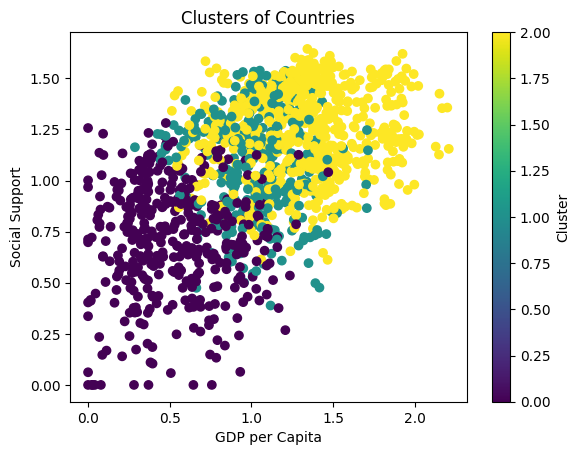

In [87]:
# create a scatter plot
plt.scatter(df_clustered_pandas["GDP_per_Capita"],df_clustered_pandas["Social_Support"],
            c=df_clustered_pandas["cluster"],cmap="viridis")
plt.xlabel('GDP per Capita')
plt.ylabel('Social Support')
plt.title('Clusters of Countries')
plt.colorbar(label='Cluster')
plt.show()

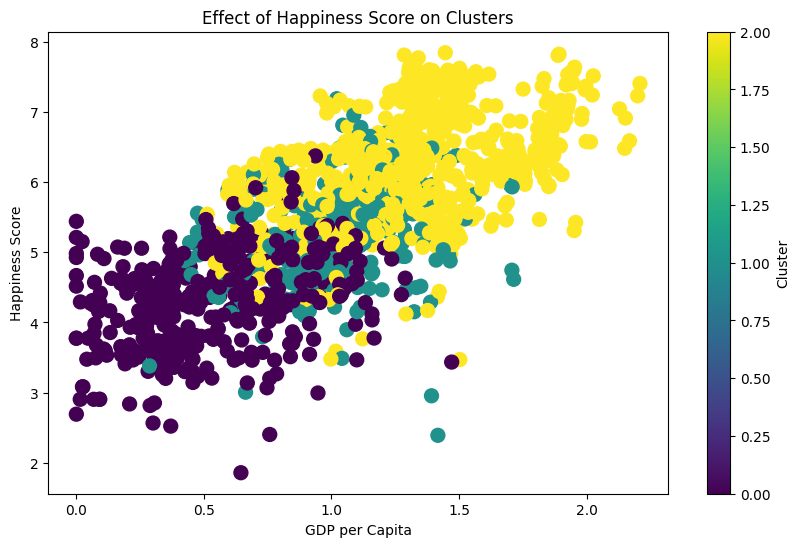

In [99]:
plt.figure(figsize=(10, 6))

# create a scatter plot happiness_score and GDP_per_capita
plt.scatter(df_clustered_pandas['GDP_per_Capita'], 
            df_clustered_pandas['Happiness_Score'], 
            c=df_clustered_pandas['cluster'], cmap='viridis', s=100)


plt.xlabel('GDP per Capita')
plt.ylabel('Happiness Score')
plt.title('Effect of Happiness Score on Clusters')

plt.colorbar(label='Cluster')

plt.show()

The cluster with the happiest countries by gdp_per_capita is 2.

In [107]:
df_cluster_2_pandas = df_clustered_pandas[df_clustered_pandas['cluster'] == 2]

df_cluster_2_pandas.head()

,Country,Region,Happiness_Score,GDP_per_Capita,Social_Support,Healthy_Life_Expectancy,Freedom_to_Make_Life_Choices,Generosity,Perceptions_of_Corruption,year,features,scaled_features,cluster
0,Switzerland,Western Europe,7.587,1.39651,1.34951,0.94143,0.66557,0.29678,0.41978,2015,"[1.39651, 1.34951, 0.94143, 0.66557]","[3.0822244918952584, 4.074012612695004, 3.8394...",2
1,Iceland,Western Europe,7.561,1.30232,1.40223,0.94784,0.62877,0.43630,0.14145,2015,"[1.30232, 1.40223, 0.94784, 0.62877]","[2.874338601431449, 4.233168117242048, 3.86564...",2
2,Denmark,Western Europe,7.527,1.32548,1.36058,0.87464,0.64938,0.34139,0.48357,2015,"[1.32548, 1.36058, 0.87464, 0.64938]","[2.9254548263294406, 4.107431645990447, 3.5671...",2
3,Norway,Western Europe,7.522,1.45900,1.33095,0.88521,0.66973,0.34699,0.36503,2015,"[1.459, 1.33095, 0.88521, 0.66973]","[3.2201456013026633, 4.017982146754315, 3.6102...",2
4,Canada,North America and ANZ,7.427,1.32629,1.32261,0.90563,0.63297,0.45811,0.32957,2015,"[1.32629, 1.32261, 0.90563, 0.63297]","[2.927242569946339, 3.992804663675363, 3.69349...",2


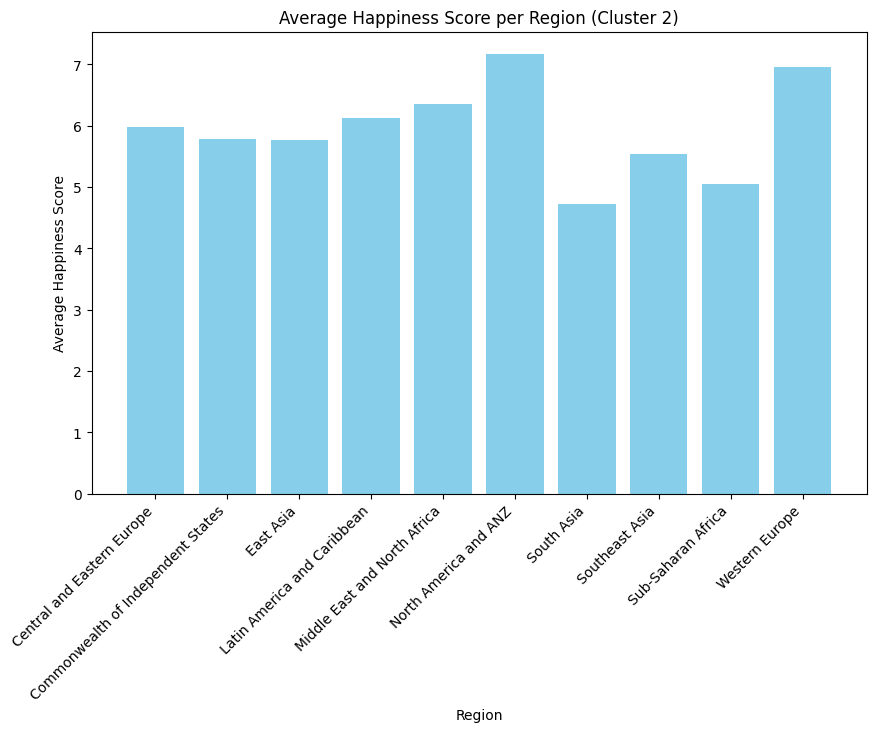

In [108]:
# AVG by región and mean of happiness_score
region_avg_happiness = df_cluster_2_pandas.groupby('Region')['Happiness_Score'].mean().reset_index()

# Create 
plt.figure(figsize=(10, 6))
plt.bar(region_avg_happiness['Region'], region_avg_happiness['Happiness_Score'], color='skyblue')

# Title
plt.xlabel('Region')
plt.ylabel('Average Happiness Score')
plt.title('Average Happiness Score per Region (Cluster 2)')
plt.xticks(rotation=45, ha='right')

# Show
plt.show()

In [106]:
region_avg_happiness

,Region,Happiness_Score
0,Central and Eastern Europe,5.976119
1,Commonwealth of Independent States,5.789070
2,East Asia,5.760136
3,Latin America and Caribbean,6.128836
4,Middle East and North Africa,6.352698
5,North America and ANZ,7.176058
6,South Asia,4.715560
7,Southeast Asia,5.531022
8,Sub-Saharan Africa,5.045718
9,Western Europe,6.955314


North America and ANZ and Western Europe are the happiest areas in this dataset, as they have the highest happiness scores.

In [5]:
spark.stop()